In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import pickle
import datetime
import time
import re

In [2]:
df = pd.read_parquet('merge_book_sentiment_2015_30_5.parquet', engine='pyarrow')

In [3]:
df.shape

(823358, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823358 entries, 0 to 823357
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   reviewerID              823358 non-null  object 
 1   asin                    823358 non-null  object 
 2   overall                 823358 non-null  int16  
 3   title                   823274 non-null  object 
 4   verified                823358 non-null  bool   
 5   summary                 822112 non-null  object 
 6   reviewText              823236 non-null  object 
 7   timestamp               823358 non-null  object 
 8   description             709561 non-null  object 
 9   price                   700232 non-null  float64
 10  Format:                 814068 non-null  object 
 11  main_cat                823313 non-null  object 
 12  brand                   820534 non-null  object 
 13  unixReviewTime          823358 non-null  float64
 14  genre               

In [5]:
df.head()

,reviewerID,asin,overall,title,verified,summary,reviewText,timestamp,description,price,Format:,main_cat,brand,unixReviewTime,genre,imageURL,review_sentiment_score
0,ALUGXJE8QRTT8,0001384198,3,The Little Engine That Could,False,I didn't enjoy it at all.,We recently joined Dolly Partons Imagination L...,2016-06-29,"When the other engines refuse, the Little Blue...",16.04,Kindle Edition,Books,Piper Watty,1.467158e+09,[fiction],None,0.408181
1,AJ133AQBUHY7B,0001384198,4,The Little Engine That Could,True,Four Stars,the little blue engine never rage quit even th...,2016-04-15,"When the other engines refuse, the Little Blue...",16.04,Hardcover,Books,Piper Watty,1.460678e+09,[fiction],None,0.619280
2,ATO9XRWKWG13I,0001384198,5,The Little Engine That Could,True,Five Stars,Good product and good service.,2015-03-06,"When the other engines refuse, the Little Blue...",16.04,Paperback,Books,Piper Watty,1.425600e+09,[fiction],None,0.989993
3,A32TLMERXASISG,0001716069,5,I Can Lick 30 Tigers Today! (Dr.Seuss Classic ...,False,New Suess for me!,The beautiful part about this book is both the...,2015-09-02,Pride and over-confidence may take many forms....,48.21,Hardcover,Books,Visit Amazon's Dr. Seuss Page,1.441152e+09,"[poetry, fiction]",None,0.922831
4,A1N3Q5GDH2VG23,0001720392,5,Green Eggs and Ham,True,Five Stars,bought as a gift,2017-12-22,None,4.62,Hardcover,Books,Visit Amazon's Dr. Seuss Page,1.513901e+09,[child],None,0.970058


# 평점 별 감성점수 평균

In [13]:
overall_review_sentiment_mean = df.groupby('overall')['review_sentiment_score'].mean()

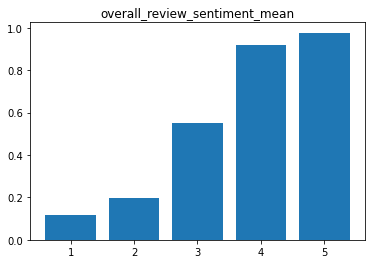

In [14]:
plt.bar(overall_review_sentiment_mean.index, overall_review_sentiment_mean)
plt.title('overall_review_sentiment_mean')
plt.show()

# 평점 매기는 습관

In [45]:
def overall_count(a):
    return a.overall.nunique()

In [46]:
user_overall_nunique = df.groupby('reviewerID').apply(overall_count)

In [47]:
uon_vc = pd.DataFrame(user_overall_nunique)[0].value_counts()

### user들이 평점 다양하게 매기는 정도 (1이 뜻하는 것은 하나의 평점만 준다는 뜻 ex.모든 책에 평점을 5점만 준다)

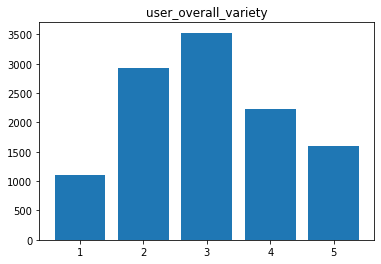

In [48]:
plt.bar(uon_vc.index, uon_vc)
plt.title('user_overall_variety')
plt.show()

## 1개 평점만 주는 사람들

In [49]:
only_1_overall_users = list(user_overall_nunique[user_overall_nunique==1].index)

In [50]:
# 약 99.5%는 그냥 5점으로 다 줌
df[df.reviewerID.isin(only_1_overall_users)].drop_duplicates('reviewerID').overall.value_counts()

5    1099
4       5
3       1
Name: overall, dtype: int64

### 이 사람들의 감성 점수 - review 감성점수도 실제로 대부분 높음

In [51]:
df[df.reviewerID.isin(only_1_overall_users)].review_sentiment_score.describe([0.001,0.01,0.1])

count    56158.000000
mean         0.977116
std          0.097643
min          0.003531
0.1%         0.027439
1%           0.442766
10%          0.970182
50%          0.998235
max          0.999507
Name: review_sentiment_score, dtype: float64

# 평점 3점의 리뷰 감성점수 분포

In [38]:
df[df.overall==3].review_sentiment_score.describe([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count    52852.000000
mean         0.549489
std          0.426699
min          0.001805
10%          0.007777
20%          0.025189
30%          0.089360
40%          0.305153
50%          0.708006
60%          0.911398
70%          0.969157
80%          0.988918
90%          0.996319
max          0.999408
Name: review_sentiment_score, dtype: float64

### 평점 4점 이상인데, 리뷰 감성점수 낮은 경우

In [7]:
len(df[(df.overall>=4)&(df.review_sentiment_score<0.5)])

21060

In [87]:
df[(df.overall>=4)&(df.review_sentiment_score<0.5)].reviewText.iloc[5]

"I had to get used to the author's writing style.  Lot's of stories going on.  Could've been at least two great books."

### 평점 2점 이하인데, 리뷰 감성점수 높은 경우

In [8]:
len(df[(df.overall<=2)&(df.review_sentiment_score>=0.5)])

3301

# 평점 단순, 다양하게 주는 사람들 간 감성점수 비교

In [78]:
overall_users_dict = {}
for i in range(1,6):
    overall_users = list(user_overall_nunique[user_overall_nunique==i].index)
    df2 = df[df.reviewerID.isin(overall_users)]
    overall_users_dict[i] = len(df2[(df2.overall==5)&(df2.review_sentiment_score<0.5)]) / len(df2[(df2.overall==5)])

### 의외로 평점 다양하게 줬을때 5점에서 부정감성 더 많음(차이가 크지 않음)

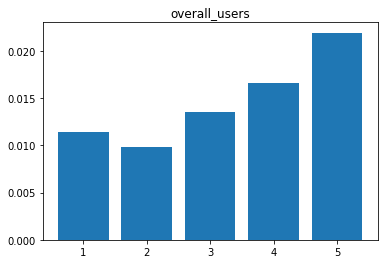

In [79]:
plt.bar(overall_users_dict.keys(), overall_users_dict.values())
plt.title('overall_users')
plt.show()

In [80]:
overall_users_dict = {}
for i in range(1,6):
    overall_users = list(user_overall_nunique[user_overall_nunique==i].index)
    df2 = df[df.reviewerID.isin(overall_users)]
    overall_users_dict[i] = len(df2[(df2.overall>=4)&(df2.review_sentiment_score<0.5)]) / len(df2[(df2.overall>=4)])

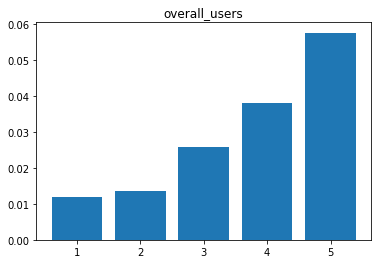

In [81]:
plt.bar(overall_users_dict.keys(), overall_users_dict.values())
plt.title('overall_users')
plt.show()

# 리뷰 길이의 차이?

In [100]:
len_overall_dict = {}
for i in range(1,6):
    overall_users = list(user_overall_nunique[user_overall_nunique==i].index)
    df2 = df[df.reviewerID.isin(overall_users)]
    n = 0
    for r in df2.reviewText:
        if r:
            n += len(r)
    len_overall_dict[i] = n / len(df1)

### 점수 한개만 준 경우 리뷰 길이 짧음

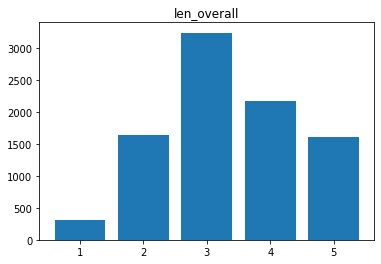

In [102]:
plt.bar(len_overall_dict.keys(), len_overall_dict.values())
plt.title('len_overall')
plt.show()

### 리뷰 긍부정 각각 리뷰 길이 비교

In [105]:
n = 0
for i in df[df.review_sentiment_score>=0.5].reviewText:
    n += len(i)

In [106]:
m = 0
for i in df[df.review_sentiment_score<0.5].reviewText:
    m += len(i)

In [107]:
n / len(df[df.review_sentiment_score>=0.5])

608.415082256092

In [108]:
m / len(df[df.review_sentiment_score<0.5])

632.386125529408